In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class Vector(object):

    def __init__(self, start, end):
        self.start = start
        self.end = end
        self.centroid = (start + end) / 2
        
    def __sub__(self, other):
        return Vector(self.end, other.start)
    
    def intersects(self, other):
        # check if two vectors intersect
        return self.start <= other.end and other.start <= self.end
    
    # def __getitem__(self, key):
    #     if key == 0:
    #         return (self.start, self.end)
    #     else:
    #         raise IndexError('Index out of range')
    
    def __len__(self):
        return self.end - self.start
    
    def __str__(self):
        return f'({self.start}, {self.end})'

In [3]:
df = pd.read_csv('../datasets/fluencybank/csv/test/reading_test.csv')
df['annotations'] = df.iloc[:, 2:].apply(lambda row: [Vector(row[0], row[1]), row[2:-1], [row[-1]]], axis=1)
df['timeVr'] = df['annotations'].apply(lambda x: x[0])
df = df['media_file anotator annotations timeVr'.split()]
df_gold = df[df['anotator']=='Gold'] 
# get the annotation df from A1 and A2
df_ann = df[df['anotator'].isin(['A1','A2', 'A3'])]
df.head()

,media_file,anotator,annotations,timeVr
0,50fb.wav,A1,"[(9267, 9597), [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","(9267, 9597)"
1,50fb.wav,A1,"[(10096, 10738), [0, 0, 0, 0, 1, 0, 0, 0, 0, 0...","(10096, 10738)"
2,50fb.wav,A1,"[(12176, 19803), [0, 0, 0, 0, 0, 0, 0, 1, 1, 0...","(12176, 19803)"
3,50fb.wav,A1,"[(28352, 41588), [0, 0, 0, 0, 0, 0, 0, 1, 0, 0...","(28352, 41588)"
4,50fb.wav,A1,"[(42352, 48470), [0, 1, 0, 0, 0, 0, 0, 1, 0, 0...","(42352, 48470)"


In [4]:
#  define Distance functions

def iou(a:Vector, b: Vector):
    intersection = max(0, min(a.end, b.end) - max(a.start, b.start))
    union = len(a) + len(b) - intersection
    return intersection / union

def iou_multiple(vas, vbs):
    return np.mean([iou(va, vb) for va in vas for vb in vbs])

def normalized_hamming_distance(label1, label2):
    differences = sum(1 for l1, l2 in zip(label1, label2) if l1 != l2)
    hamming_distance = differences / len(label1)
    return hamming_distance

def normalized_ordinal_distance(ordinal1, ordinal2, max_value=3):
    ordinal_distance = abs(ordinal1 - ordinal2) / max_value
    return ordinal_distance

def normalized_ordinal_distance_multiple(ordinal1s, ordinal2s, max_value):
    return np.mean([normalized_ordinal_distance(o1, o2) for o1 in ordinal1s for o2 in ordinal2s])

def normalized_hamming_distance_multiple(labels1, labels2):
    return np.mean([normalized_hamming_distance(l1, l2) for l1 in labels1 for l2 in labels2])

def score(row1, row2, weights=(0.33, 0.33, 0.34)):
    iou_score = iou(row1[0], row2[0])
    hamming_score = normalized_hamming_distance(row1[1], row2[1])
    ordinal_score = normalized_ordinal_distance(row1[2], row2[2], 3)
    return sum([iou_score * weights[0], hamming_score * weights[1], ordinal_score * weights[2]])

def score_multiple(row1, row2):
    return np.mean([score(r1, r2) for r1 in row1 for r2 in row2])




In [5]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import euclidean_distances
from collections import defaultdict
import copy

def unionize_vectorrange_sequence(vectorranges):
    min_s = min([vr.start for vr in vectorranges])
    max_e = max([vr.end for vr in vectorranges])
    return Vector(min_s, max_e)

def fragment_by_overlaps(annodf, uid_colname, item_colname, label_colname, decomp_fn, dist_fn=None, gold_df=None):
    resultdfs = []
    for item_id in annodf[item_colname].unique():
        idf = annodf[annodf[item_colname] == item_id]
        vectorranges = [vas[0] for vas in idf[label_colname]]

        regions = decomp_fn(vectorranges, dist_fn=dist_fn)
        origItemID = []
        newItemID = []
        newItemVR = []
        uid = []
        label = []
        gold = []
        for region in regions:
            for i, row in idf.iterrows():
                if region.intersects(row[label_colname][0]):
                    origItemID.append(item_id)
                    newItemID.append(F"{item_id}-{region}")
                    newItemVR.append(region)
                    uid.append(row[uid_colname])
                    label.append(row[label_colname])
                    if gold_df is not None:
                        # get the gold label that intersects with the region
                        gold_label = [vr[0] for vr in gold_df[(gold_df[item_colname] == item_id)][label_colname] if region.intersects(vr[0])]
                        gold.append(gold_label)
                    else:
                        gold.append(None)
        resultdfs.append(pd.DataFrame({"origItemID":origItemID, "newItemID":newItemID, "newItemVR":newItemVR, uid_colname:uid, label_colname:label, "gold":gold}))
    return pd.concat(resultdfs)

def decomp_fn(vectorranges, use_centroids=True, dist_fn=None):

    if use_centroids:
        centroids = np.array([vr.centroid for vr in vectorranges]).reshape(-1, 1)
        # dists = euclidean_distances(centroids)
        # mean_dist = np.std(dists)
        mean_dist = 1000
        clustering = AgglomerativeClustering(n_clusters=None,
                                             distance_threshold=mean_dist)
        clustering.fit(centroids)
    else:
        dists = np.array([[1 - iou(a, b) for a in vectorranges] for b in vectorranges])
        mean_dist = np.std(dists)
        clustering = AgglomerativeClustering(n_clusters=None,
                                             distance_threshold=mean_dist,
                                             affinity="precomputed",
                                             linkage="average")
        clustering.fit(dists)
        
    labels = clustering.labels_
    labeldict = defaultdict(list)
    for i, label in enumerate(labels):
        labeldict[label].append(i)
    result = []
    for indices in labeldict.values():
        uv = unionize_vectorrange_sequence(np.array(vectorranges)[np.array(indices)])
        result.append(uv)

    return result

grannodf = fragment_by_overlaps(df_ann, "anotator", "media_file", "annotations", decomp_fn, gold_df=df_gold)
grannodf['gold'] = grannodf['gold'].apply(lambda x: x[0] if len(x) > 0 else None)
grannodf.head()

,origItemID,newItemID,newItemVR,anotator,annotations,gold
0,50fb.wav,"50fb.wav-(9267, 9597)","(9267, 9597)",A1,"[(9267, 9597), [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",None
1,50fb.wav,"50fb.wav-(10050, 10738)","(10050, 10738)",A1,"[(10096, 10738), [0, 0, 0, 0, 1, 0, 0, 0, 0, 0...","(10050, 10738)"
2,50fb.wav,"50fb.wav-(10050, 10738)","(10050, 10738)",A2,"[(10050, 10550), [0, 0, 0, 0, 1, 0, 0, 0, 0, 1...","(10050, 10738)"
3,50fb.wav,"50fb.wav-(11710, 19850)","(11710, 19850)",A1,"[(12176, 19803), [0, 0, 0, 0, 0, 0, 0, 1, 1, 0...","(11710, 19850)"
4,50fb.wav,"50fb.wav-(11710, 19850)","(11710, 19850)",A2,"[(12470, 19020), [0, 0, 0, 0, 0, 0, 0, 1, 1, 0...","(11710, 19850)"


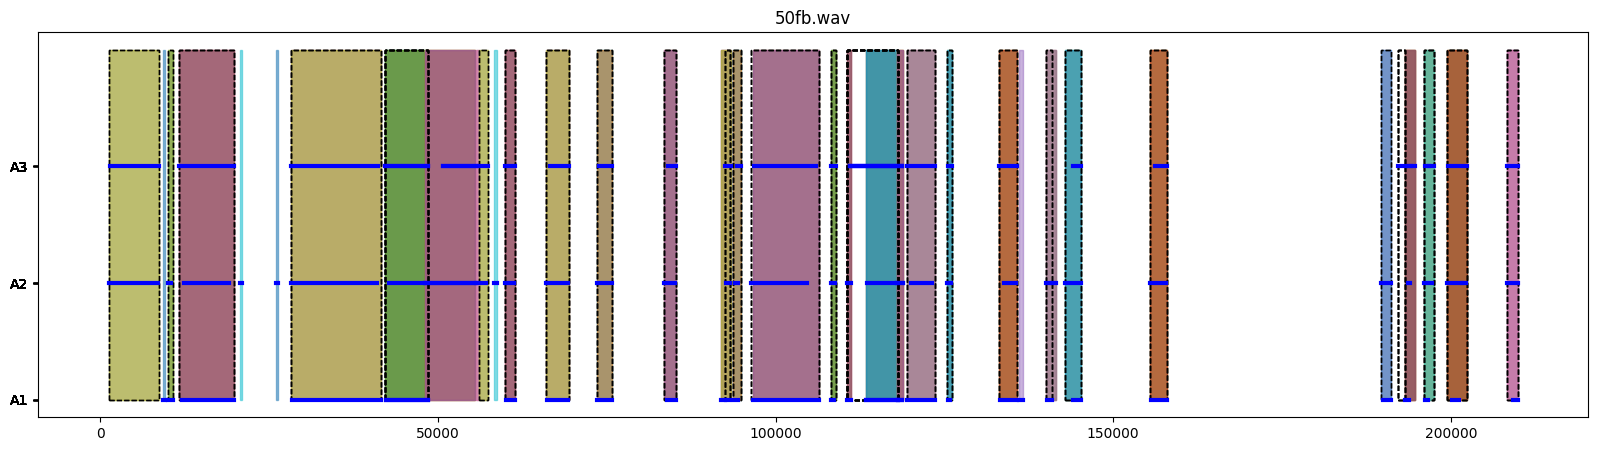

""


In [6]:
# visualize groupings
from matplotlib.patches import Rectangle
def plot_vectorranges(vr,y, color='b', linewidth=1, alpha=1):
    plt.plot([vr.start, vr.end], y, color=color, linewidth=linewidth, alpha=alpha)

def plot_ann(data):
    vrs = [va[0] for va in data['annotations']]
    ys = [i for i in data['anotator_id']]
    unique_items = data['newItemID'].unique()

    # colors = sns.color_palette('tab10', n_colors=len(unique_items))

    fig, ax = plt.subplots(figsize=(20, 5))
    for vr, y in zip(vrs, ys):
        plot_vectorranges(vr, [y,y], linewidth=3)

    colors = sns.color_palette('tab10', n_colors=len(unique_items))
    # plot the groupings
    for i,vr in enumerate(data['newItemVR']):
        color = i % len(colors)
        ax.add_patch(Rectangle((vr.start, 0), len(vr), 3, alpha=0.5, color=colors[color]))
    # plot the gold annotation with dashed rectangle
    for i,vr in enumerate(data['gold']):
        if vr:
            ax.add_patch(Rectangle((vr.start, 0), len(vr), 3, linestyle='--', facecolor='none', fill=None))

    plt.yticks(ys, data['anotator'])
    plt.title(data['origItemID'].values[0])
    plt.show()

grannodf['anotator_id'] = grannodf['anotator'].astype('category').cat.codes
grannodf['timeVr'] = grannodf['annotations'].apply(lambda x: x[0])
grannodf.iloc[:100].groupby('origItemID').apply(plot_ann)

### Calculate the iaa using Time Span only 

In [7]:
df_gold['timeVr'] = df_gold['annotations'].apply(lambda x: x[0])
df_gold.head()

/tmp/ipykernel_2038481/1057102032.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gold['timeVr'] = df_gold['annotations'].apply(lambda x: x[0])


,media_file,anotator,annotations,timeVr
130,50fb.wav,Gold,"[(10050, 10738), [0, 0, 0, 0, 1, 0, 0, 0, 0, 1...","(10050, 10738)"
131,50fb.wav,Gold,"[(11710, 19850), [0, 0, 0, 0, 0, 0, 0, 1, 1, 0...","(11710, 19850)"
132,50fb.wav,Gold,"[(28190, 41588), [0, 0, 0, 0, 0, 0, 0, 1, 0, 0...","(28190, 41588)"
133,50fb.wav,Gold,"[(59890, 61470), [0, 0, 0, 0, 0, 0, 0, 0, 1, 0...","(59890, 61470)"
134,50fb.wav,Gold,"[(66030, 69400), [0, 0, 0, 0, 0, 0, 0, 0, 1, 0...","(66030, 69400)"


In [8]:
import sys
sys.path.append("../annotationmodeling")
from experiments import RealExperiment
iaa_exp = RealExperiment(eval_fn=iou,label_colname="timeVr",
                                                    item_colname="newItemID", uid_colname="anotator")
iaa_exp.setup(grannodf, golddf=grannodf, c_gold_item="newItemID", c_gold_label="timeVr")

100%|██████████| 406/406 [00:00<00:00, 721.31it/s] 


In [9]:
iaa_exp.train(iter=0, masX_iter=0)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f2f75b1a490cf818851956f5849af989 NOW.


Pickled model not found
Compiling model
../annotationmodeling/stan_files/dem_semisup


cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
In file included from /fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/aa/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/aa/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/aa/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /tmp/pystan_4bi81idj/stanfit4anon_model_f2f75b1a490cf818851956f5849af989_3460206508368497731.cpp:1315:
/fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/aa/lib/python3.8/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with "

Pickling model
Initial log joint probability = -158.996
Pickled model not found
Compiling model
../annotationmodeling/stan_files/mas2_semisup
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -151.089     0.0990644       62.2014       0.001       0.001        2   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       2      -143.689      0.193771       27.4088           1           1        3   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       3      -140.434      0.150733       32.1543           1           1        4   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       4      -129.321      0.632955       57.6994           1           1        5   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       5      -107.951       1.39539       83.2864

DIAGNOSTIC(S) FROM PARSER:
Info: Comments beginning with # are deprecated.  Please use // in place of # for line comments.
Info: Comments beginning with # are deprecated.  Please use // in place of # for line comments.

cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
In file included from /fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/aa/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/aa/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/aa/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /tmp/pystan_1qqlvmei/stanfit4anon_model_0a42423d6797de0c623e8873b9455595_7036167344831036864.cpp:1315:
/fsx/homes/Rufael.Marew@mbzuai.ac.ae/miniconda3/envs/aa/lib/python3.8/site-packages/numpy/core/include/numpy

Pickling model
Initial log joint probability = -21955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -18005.8       10.2975       6456.85   0.0003871       0.001        4   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       2      -13258.2      0.965009       3773.29       0.484       0.484        5   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       3      -9206.91       1.44681       2118.67           1           1        6   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       4      -6556.47       1.97579       1046.37           1           1        7   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       5      -5535.37        1.2743        1002.5           1           1        8   
    Iter      log prob        ||dx||      ||grad|| 

In [10]:
# iaa_exp.mas_preds
iaa_exp.test(debug=False)

AttributeError: 'NoneType' object has no attribute 'get'

In [11]:
iaa_exp.scoreboard

{'RANDOM USER': 0.7613860050459563,
 'BEST AVAILABLE USER': 0.6389909832649846,
 'SMALLEST AVERAGE DISTANCE': 0.6662513994082724,
 'DISTANCE EXPECTATION MAXIMIZATION': 0.756665011626265,
 'MULTIDIMENSIONAL ANNOTATION SCALING': 0.747354887836478}

In [12]:
iaa_exp.calc_krippendorf_alpha_ours()

 25%|██▍       | 100/406 [00:00<00:00, 982.49it/s]

100%|██████████| 406/406 [00:00<00:00, 688.87it/s]


0.49024727974357096